# Content

- Preparation
- Recap: VGG16 (naive)
- Sequential container
- Building ResNet
- Exercise: Build VGG16

# Preparation

In [1]:
!nvidia-smi

Wed Dec 21 12:51:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

In [3]:
# DEVICE 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Recap: VGG16 (naive)

- [doc] (https://arxiv.org/pdf/1409.1556.pdf)

![image.png](http://drive.google.com/uc?id=1E6MVIcFCsImwWQGOhC-8KUQqAe2W_I28)

In [4]:
# Model 구현
class VGG16_naive(nn.Module):
    def __init__(self):
        super(VGG16_naive, self).__init__()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()

        self.conv1_1 = nn.Conv2d(3,64,3,padding=1)
        self.conv1_2 = nn.Conv2d(64,64,3,padding=1)

        self.conv2_1 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)

        self.conv3_1 = nn.Conv2d(128,256,3,padding=1)
        self.conv3_2 = nn.Conv2d(256,256,3,padding=1)
        self.conv3_3 = nn.Conv2d(256,256,3,padding=1)

        self.conv4_1 = nn.Conv2d(256,512,3,padding=1)
        self.conv4_2 = nn.Conv2d(512,512,3,padding=1)
        self.conv4_3 = nn.Conv2d(512,512,3,padding=1)

        self.conv5_1 = nn.Conv2d(512,512,3,padding=1)
        self.conv5_2 = nn.Conv2d(512,512,3,padding=1)
        self.conv5_3 = nn.Conv2d(512,512,3,padding=1)
        self.adaptiveavgpool2d = nn.AdaptiveAvgPool2d((7,7))
        self.fc1 = nn.Linear(512*7*7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.maxpool2d(x)

        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.maxpool2d(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.maxpool2d(x)
        
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.maxpool2d(x)
        
        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.maxpool2d(x)
        
        x = self.adaptiveavgpool2d(x)
        x = x.view(-1,512*7*7)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Sequential container

In [5]:
# Layer as parameter
seq = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(256, 512)
).to(DEVICE)
seq

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=512, bias=True)
)

In [6]:
summary(seq, (64,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 256]          25,856
              ReLU-2              [-1, 64, 256]               0
           Dropout-3              [-1, 64, 256]               0
            Linear-4              [-1, 64, 512]         131,584
Total params: 157,440
Trainable params: 157,440
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.62
Params size (MB): 0.60
Estimated Total Size (MB): 1.25
----------------------------------------------------------------


### Use Array

In [7]:
# Layer as a element of Array
layers = [
        nn.Conv2d(3, 256, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(),
        nn.Conv2d(256, 512, 3, 1, 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(),
        ]

seq = nn.Sequential(*layers).to(DEVICE)
seq

Sequential(
  (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
)

In [8]:
summary(seq, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           7,168
              ReLU-2          [-1, 256, 32, 32]               0
       BatchNorm2d-3          [-1, 256, 32, 32]             512
           Dropout-4          [-1, 256, 32, 32]               0
            Conv2d-5          [-1, 512, 32, 32]       1,180,160
       BatchNorm2d-6          [-1, 512, 32, 32]           1,024
              ReLU-7          [-1, 512, 32, 32]               0
           Dropout-8          [-1, 512, 32, 32]               0
Total params: 1,188,864
Trainable params: 1,188,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 24.00
Params size (MB): 4.54
Estimated Total Size (MB): 28.55
----------------------------------------------------------------


### Use Ordered Dictionary

In [9]:
from collections import OrderedDict

layers = OrderedDict([
        ('conv1', nn.Conv2d(3, 256, 3, 1, 1)),
        ('bn1', nn.BatchNorm2d(256)),
        ('relu1', nn.ReLU()),
        ('dropout1', nn.Dropout()),
        ('conv2', nn.Conv2d(256, 512, 3, 1, 1)),
        ('bn2', nn.BatchNorm2d(512)),
        ('relu2', nn.ReLU()),
        ('dropout2', nn.Dropout()),
        ])

seq = nn.Sequential(layers).to(DEVICE)
seq

Sequential(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [10]:
summary(seq, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           7,168
       BatchNorm2d-2          [-1, 256, 32, 32]             512
              ReLU-3          [-1, 256, 32, 32]               0
           Dropout-4          [-1, 256, 32, 32]               0
            Conv2d-5          [-1, 512, 32, 32]       1,180,160
       BatchNorm2d-6          [-1, 512, 32, 32]           1,024
              ReLU-7          [-1, 512, 32, 32]               0
           Dropout-8          [-1, 512, 32, 32]               0
Total params: 1,188,864
Trainable params: 1,188,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 24.00
Params size (MB): 4.54
Estimated Total Size (MB): 28.55
----------------------------------------------------------------


# Example : Build Resnet18


[Deep Residual Learning for Image Recognition] https://arxiv.org/abs/1512.03385


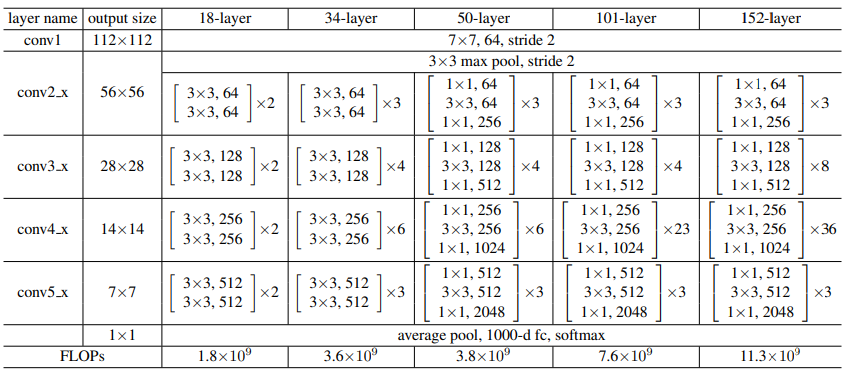

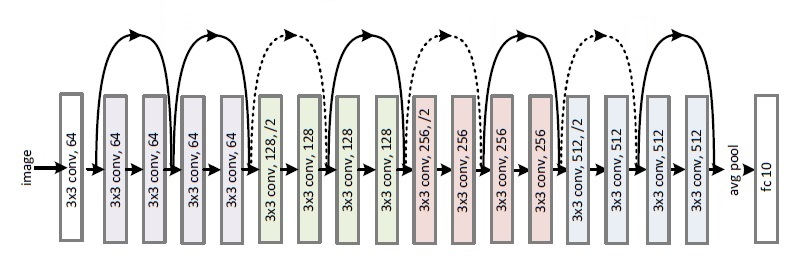

## Skip connection

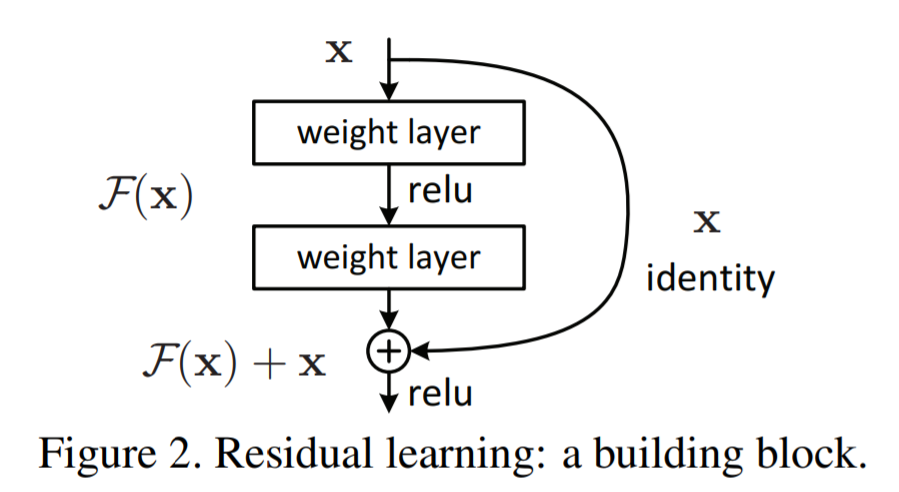

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(BasicBlock, self).__init__()
        # downsample 
        self.downsample = downsample
        if self.downsample:
            layers = [nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias=False)]
        else:
            layers = [nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)]
        
        # stack layers
        layers += [nn.BatchNorm2d(out_channels),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
                   nn.BatchNorm2d(out_channels)]
        # layers
        self.layer = nn.Sequential(*layers)
        self.down = nn.Conv2d(in_channels, out_channels, 1, 2, 0, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        # downsample
        if self.downsample:
            identity = self.down(x)

        # residual learning
        out = self.layer(x)
        out += identity  # should be same size
        out = self.relu(out)

        return out

In [20]:
model = BasicBlock(in_channels = 64, out_channels = 64).to(DEVICE)

In [21]:
summary(model, (64,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          36,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 3.00
Params size (MB): 0.28
Estimated Total Size (MB): 3.53
----------------------------------------------------------------


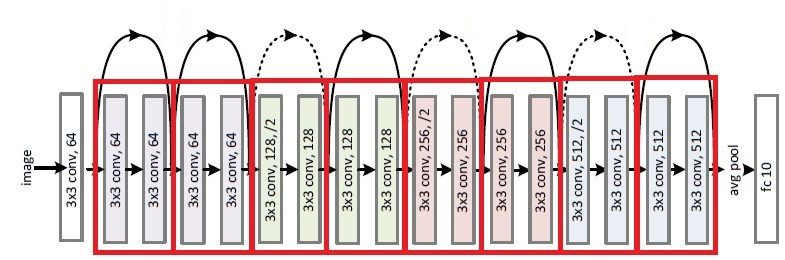

In [14]:
class ResNet18(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, 2, 1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.MaxPool2d(2, 2),
                                   BasicBlock(64, 64),
                                   BasicBlock(64, 64))
        self.conv3 = nn.Sequential(BasicBlock(64, 128, True),
                                   BasicBlock(128, 128))
        self.conv4 = nn.Sequential(BasicBlock(128, 256, True),
                                   BasicBlock(256, 256))
        self.conv5 = nn.Sequential(BasicBlock(256, 512, True),
                                   BasicBlock(512, 512))
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [22]:
model = ResNet18(3, 10).to(DEVICE)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,408
       BatchNorm2d-2         [-1, 64, 110, 110]             128
              ReLU-3         [-1, 64, 110, 110]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5           [-1, 64, 55, 55]          36,864
       BatchNorm2d-6           [-1, 64, 55, 55]             128
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]          36,864
       BatchNorm2d-9           [-1, 64, 55, 55]             128
             ReLU-10           [-1, 64, 55, 55]               0
       BasicBlock-11           [-1, 64, 55, 55]               0
           Conv2d-12           [-1, 64, 55, 55]          36,864
      BatchNorm2d-13           [-1, 64, 55, 55]             128
             ReLU-14           [-1, 64,

# Exercise: Build VGG16

Input Size: 32 x 32

Add 7 x 7 Average Pooling before FC

the number of classes: 10

- [doc] (https://arxiv.org/pdf/1409.1556.pdf)

![image.png](http://drive.google.com/uc?id=1E6MVIcFCsImwWQGOhC-8KUQqAe2W_I28)

## Start with small blocks

In [16]:
class SmallBlock(nn.Module):
    # in_channels: input channels of block
    # out_channels: output channels of block
    # num_layers: the number of convolution layers in block
    def __init__(self, in_channels, out_channels, num_layers):
        super(SmallBlock, self).__init__()
        ########### Write Code Here ###########

In [17]:
model = SmallBlock(128, 256, 3).to(DEVICE)
summary(model, (128,16,16))

NotImplementedError: ignored

## Final Model

In [ ]:
class VGG(nn.Module):
    # channels: array which has input channels and output channels for each blocks
    # num_layers: array which has the number of conv layers in each block
    # in_channels: input channels(RGB: 3, grayscale: 1)
    # num_classes: the number of predicted classes
    def __init__(self, channels, num_layers, in_channels=3, num_classes=10):
        super(VGG, self).__init__()
        ########### Write Code Here ###########
    
    def forward(self, x):
        ########### Write Code Here ###########

In [ ]:
# VGG-16
channels = [(3, 64), (64, 128), (128, 256), (256, 512), (512, 512)]
num_layers = [2, 2, 3, 3, 3]
model = VGG(channels, num_layers, 3, 10).to(DEVICE)

In [ ]:
# Summarize Model
summary(model, (3, 32, 32))

# Training

## Prepare Dataset

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset = CIFAR10(root='./CIFAR10', train=True, transform=transform, download=True)
testset = CIFAR10(root='./CIFAR10', train=False, transform=transform)

In [ ]:
from torch.utils.data import DataLoader
from multiprocessing import cpu_count
batch_size = 512
num_workers = int(cpu_count() / 2)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

## Prepare Model

In [ ]:
from torch.nn import CrossEntropyLoss

channels = [(3, 64), (64, 128), (128, 256), (256, 512), (512, 512)]
num_layers = [2, 2, 3, 3, 3]
model = VGG(channels, num_layers).to(DEVICE) # initialized 

epochs = 5

criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, verbose=True)

## Train

In [ ]:
model.train()
for epoch in range(epochs):
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(x)
        # pred: (batch_size, 1), y: (batch_size, 1)
        train_loss = criterion(pred, y)

        train_loss.backward()
        optimizer.step()

    print('Train loss at {} is {}'.format(epoch, train_loss.item()))

## Evaluation

In [ ]:
test_loss = 0

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        pred = model(x)
        test_loss += criterion(pred, y).item() * len(y)

test_loss /= len(test_data)
print('Test Loss is', test_loss)